In [46]:
from datetime import timedelta
import sys
import os
parentdir = os.getcwd()
# print(parentdir)
# sys.path.insert(0, parentdir)
module_path = os.path.abspath(os.path.join('..'))[:-8]
if module_path not in sys.path:
    sys.path.append(module_path)
from copy import deepcopy
import pandas as pd
from numpy import std, mean, log
from random import choice, sample
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import bamt.preprocessors as pp
import bamt.networks as Nets
from golem.core.optimisers.optimization_parameters import GraphRequirements
from golem.core.dag.verification_rules import has_no_cycle, has_no_self_cycled_nodes
from golem.core.adapter import DirectAdapter
from golem.core.optimisers.genetic.gp_optimizer import EvoGraphOptimizer
from golem.core.optimisers.genetic.gp_params import GPAlgorithmParameters
from golem.core.dag.convert import graph_structure_as_nx_graph
from golem.core.optimisers.genetic.operators.inheritance import GeneticSchemeTypesEnum
from golem.core.optimisers.genetic.operators.selection import SelectionTypesEnum
from golem.core.optimisers.objective.objective import Objective
from golem.core.optimisers.objective.objective_eval import ObjectiveEvaluate
from golem.core.optimisers.optimizer import GraphGenerationParams
from golem.core.dag.linked_graph import LinkedGraph
from golem.core.dag.graph_utils import ordered_subnodes_hierarchy
from math import ceil
from scipy.stats import norm
from itertools import chain
from composite_model import CompositeModel
from composite_node import CompositeNode
from ML import ML_models


In [32]:
# файл с исходными данными (должен лежать в 'examples/data/')
file = 'healthcare'
k = 1
# размер популяции 
pop_size = 20
# количество поколений
n_generation = 1000
# вероятность кроссовера
crossover_probability = 0.8
# вероятность мутации
mutation_probability = 0.9
time_m = 15
n = 1
number = 1

Задаем fitness-функцию

In [33]:
def composite_metric(graph: CompositeModel, data: pd.DataFrame):
    try:
        data_all = data
        data_train , data_test = train_test_split(data_all, train_size = 0.8, random_state=42)
        score, len_data = 0, len(data_train)
        for node in graph.nodes:   
            data_of_node_train = data_train[node.content['name']]
            data_of_node_test = data_test[node.content['name']]
            if node.nodes_from == None or node.nodes_from == []:
                if node.content['type'] == 'cont':
                    mu, sigma = mean(data_of_node_train), std(data_of_node_train)
                    score += norm.logpdf(data_of_node_test.values, loc=mu, scale=sigma).sum()
                else:
                    count = data_of_node_train.value_counts()
                    frequency  = log(count / len_data)
                    index = frequency.index.tolist()
                    for value in data_of_node_test:
                        if value in index:
                            score += frequency[value]

            else:
                model, columns, target, idx = node.content['parent_model'](), [n.content['name'] for n in node.nodes_from], data_of_node_train.to_numpy(), data_train.index.to_numpy()
                features = data_train[columns].to_numpy()
                fitted_model = model.fit(features, target)
                
                idx=data_test.index.to_numpy()
                features=data_test[columns].to_numpy()
                target=data_of_node_test.to_numpy()            
                if node.content['type'] == 'cont':
                    predict = fitted_model.predict(features)        
                    mse =  mean_squared_error(target, predict, squared=False) + 0.0000001
                    a = norm.logpdf(target, loc=predict, scale=mse)
                    score += a.sum()                
                else:
                    predict_proba = fitted_model.predict_proba(features)
                    idx = pd.array(list(range(len(target))))
                    li = []
                    
                    for i in idx:
                        a = predict_proba[i]
                        try:
                            b = a[target[i]]
                        except:
                            b = 0.0000001
                        li.append(log(b))
                    score += sum(li)
    except Exception as ax:
        print(ax)
    return -score

Задаем кроссоверы

In [34]:
def custom_crossover_exchange_edges(graph_first: CompositeModel, graph_second: CompositeModel, max_depth):

    def find_node(graph: CompositeModel, node):
        name = node.content['name']
        for graph_node in graph.nodes:
            if graph_node.content['name'] == name:
                return graph_node

    num_cros = 100
    try:
        for _ in range(num_cros):
            old_edges1 = []
            old_edges2 = []
            new_graph_first=deepcopy(graph_first)
            new_graph_second=deepcopy(graph_second)

            edges_1 = new_graph_first.operator.get_edges()
            edges_2 = new_graph_second.operator.get_edges()
            count = ceil(min(len(edges_1), len(edges_2))/2)
            choice_edges_1 = sample(edges_1, count)
            choice_edges_2 = sample(edges_2, count)
            
            for pair in choice_edges_1:
                new_graph_first.operator.disconnect_nodes(pair[0], pair[1], False)
            for pair in choice_edges_2:
                new_graph_second.operator.disconnect_nodes(pair[0], pair[1], False)  
            
            old_edges1 = new_graph_first.operator.get_edges()
            old_edges2 = new_graph_second.operator.get_edges()

            new_edges_2 = [[find_node(new_graph_second, i[0]), find_node(new_graph_second, i[1])] for i in choice_edges_1]
            new_edges_1 = [[find_node(new_graph_first, i[0]), find_node(new_graph_first, i[1])] for i in choice_edges_2] 
            for pair in new_edges_1:
                if pair not in old_edges1:
                    new_graph_first.operator.connect_nodes(pair[0], pair[1])
            for pair in new_edges_2:
                if pair not in old_edges2:
                    new_graph_second.operator.connect_nodes(pair[0], pair[1])                                             
            
            if old_edges1 != new_graph_first.operator.get_edges() or old_edges2 != new_graph_second.operator.get_edges():
                break

        if old_edges1 == new_graph_first.operator.get_edges() and new_edges_1!=[] and new_edges_1!=None:
            new_graph_first = deepcopy(graph_first)
        if old_edges2 == new_graph_second.operator.get_edges() and new_edges_2!=[] and new_edges_2!=None:
            new_graph_second = deepcopy(graph_second)
    except Exception as ex:
        print(ex)
    return new_graph_first, new_graph_second


In [35]:
def custom_crossover_exchange_parents_both(graph_first: CompositeModel, graph_second: CompositeModel, max_depth):
    
    def find_node(graph: CompositeModel, node):
        name = node.content['name']
        for graph_node in graph.nodes:
            if graph_node.content['name'] == name:
                return graph_node
    
    num_cros = 100
    try:
        for _ in range(num_cros):
            old_edges1 = []
            old_edges2 = []
            parents1 = []
            parents2 = []
            new_graph_first=deepcopy(graph_first)
            new_graph_second=deepcopy(graph_second)

            edges = new_graph_second.operator.get_edges()
            flatten_edges = list(chain(*edges))
            nodes_with_parent_or_child=list(set(flatten_edges))
            if nodes_with_parent_or_child!=[]:
                
                selected_node2=choice(nodes_with_parent_or_child)
                parents2=selected_node2.nodes_from

                selected_node1=find_node(new_graph_first, selected_node2)
                parents1=selected_node1.nodes_from
                
                if parents1:
                    for p in parents1:
                        new_graph_first.operator.disconnect_nodes(p, selected_node1, False)
                if parents2:
                    for p in parents2:
                        new_graph_second.operator.disconnect_nodes(p, selected_node2, False)

                old_edges1 = new_graph_first.operator.get_edges()
                old_edges2 = new_graph_second.operator.get_edges()

                if parents2!=[] and parents2!=None:
                    parents_in_first_graph=[find_node(new_graph_first, i) for i in parents2]
                    for parent in parents_in_first_graph:
                        if [parent, selected_node1] not in old_edges1:
                            new_graph_first.operator.connect_nodes(parent, selected_node1)

                if parents1!=[] and parents1!=None:
                    parents_in_second_graph=[find_node(new_graph_second, i) for i in parents1]
                    for parent in parents_in_second_graph:
                        if [parent, selected_node2] not in old_edges2:
                            new_graph_second.operator.connect_nodes(parent, selected_node2)            


            if old_edges1 != new_graph_first.operator.get_edges() or old_edges2 != new_graph_second.operator.get_edges():
                break    
        
        if old_edges1 == new_graph_first.operator.get_edges() and parents2!=[] and parents2!=None:
            new_graph_first = deepcopy(graph_first)                
        if old_edges2 == new_graph_second.operator.get_edges() and parents1!=[] and parents1!=None:
            new_graph_second = deepcopy(graph_second)       

    except Exception as ex:
        print(ex)    
    return new_graph_first, new_graph_second


In [36]:
def custom_crossover_all_model(graph_first: CompositeModel, graph_second: CompositeModel, max_depth):

    def find_node(graph: CompositeModel, node):
        name = node.content['name']
        for graph_node in graph.nodes:
            if graph_node.content['name'] == name:
                return graph_node    
        
    num_cros = 100
    try:
        for _ in range(num_cros):
            selected_node1=choice(graph_first.nodes)
            if selected_node1.nodes_from == None or selected_node1.nodes_from == []:
                continue
            
            selected_node2=find_node(graph_second, selected_node1)           
            if selected_node2.nodes_from == None or selected_node2.nodes_from == []:
                continue            

            model1 = selected_node1.content['parent_model']
            model2 = selected_node2.content['parent_model']

            selected_node1.content['parent_model'] = model2
            selected_node2.content['parent_model'] = model1

            break

    except Exception as ex:
        print(ex)
    return graph_first, graph_second



Задаем мутации

In [37]:
def custom_mutation_add_structure(graph: CompositeModel, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[choice(range(len(graph.nodes)))]
            nodes_not_cycling = (random_node.descriptive_id not in
                                 [n.descriptive_id for n in ordered_subnodes_hierarchy(other_random_node)] and
                                 other_random_node.descriptive_id not in
                                 [n.descriptive_id for n in ordered_subnodes_hierarchy(random_node)])
            if nodes_not_cycling:
                graph.operator.connect_nodes(random_node, other_random_node)
                break

    except Exception as ex:
        graph.log.warn(f'Incorrect connection: {ex}')
    return graph

In [38]:
def custom_mutation_delete_structure(graph: CompositeModel, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                graph.operator.disconnect_nodes(other_random_node, random_node, False)
                break
    except Exception as ex:
        print(ex) 
    return graph

In [39]:
def custom_mutation_reverse_structure(graph: CompositeModel, **kwargs):
    num_mut = 100
    try:
        for _ in range(num_mut):
            rid = choice(range(len(graph.nodes)))
            random_node = graph.nodes[rid]
            other_random_node = graph.nodes[choice(range(len(graph.nodes)))]
            if random_node.nodes_from is not None and other_random_node in random_node.nodes_from:
                graph.operator.reverse_edge(other_random_node, random_node)   
                break         
    except Exception as ex:
        print(ex)  
    return graph

In [40]:
def custom_mutation_add_model(graph: CompositeModel, **kwargs):
    try:
        all_nodes = graph.nodes
        nodes_with_parents = [node for node in all_nodes if (node.nodes_from!=[] and node.nodes_from!=None)]
        if nodes_with_parents == []:
            return graph
        node = choice(nodes_with_parents)
        ml_models = ML_models()
        node.content['parent_model'] = ml_models.get_model_by_children_type(node)
    except Exception as ex:
        print(ex)  
    return graph

In [41]:
def mutation_set1(graph: CompositeModel, **kwargs):
    return custom_mutation_add_model(custom_mutation_add_structure(graph, **kwargs))


def mutation_set2(graph: CompositeModel, **kwargs): 
    return custom_mutation_add_model(custom_mutation_delete_structure(graph, **kwargs))
        

def mutation_set3(graph: CompositeModel, **kwargs):
    return custom_mutation_add_model(custom_mutation_reverse_structure(graph, **kwargs))



def cross_set(graph_first: CompositeModel, graph_second: CompositeModel, max_depth):
    g11, g12 = custom_crossover_exchange_parents_both(graph_first, graph_second, max_depth)
    g21, g22 = custom_crossover_exchange_edges(g11, g12, max_depth)
    g31, g32 = custom_crossover_all_model(g21, g22, max_depth)
    return g31, g32

In [42]:
def connect_nodes(self, parent: CompositeNode, child: CompositeNode):
    if child.descriptive_id not in [p.descriptive_id for p in ordered_subnodes_hierarchy(parent)]:
        try:
            if child.nodes_from==None or child.nodes_from==[]:
                child.nodes_from = []
                child.nodes_from.append(parent)
                ml_models = ML_models()
                child.content['parent_model'] = ml_models.get_model_by_children_type(child)                
            else:                      
                child.nodes_from.append(parent)
        except Exception as ex:
            print(ex)

def disconnect_nodes(self, node_parent: CompositeNode, node_child: CompositeNode,
                    clean_up_leftovers: bool = True):
    if not node_child.nodes_from or node_parent not in node_child.nodes_from:
        return
    elif node_parent not in self._nodes or node_child not in self._nodes:
        return
    elif len(node_child.nodes_from) == 1:
        node_child.nodes_from = None
    else:
        node_child.nodes_from.remove(node_parent)

    if clean_up_leftovers:
        self._clean_up_leftovers(node_parent)

    self._postprocess_nodes(self, self._nodes)

    if node_child.nodes_from == [] or node_child.nodes_from == None:
        node_child.content['parent_model'] = None


def reverse_edge(self, node_parent: CompositeNode, node_child: CompositeNode):
    self.disconnect_nodes(node_parent, node_child, False)
    self.connect_nodes(node_child, node_parent)


LinkedGraph.reverse_edge = reverse_edge
LinkedGraph.connect_nodes = connect_nodes
LinkedGraph.disconnect_nodes = disconnect_nodes

Задаем правила на запрет дублирующих узлов

In [43]:
def _has_no_duplicates(graph: CompositeModel):
    _, labels = graph_structure_as_nx_graph(graph)
    if len(labels.values()) != len(set(labels.values())):
        raise ValueError('Custom graph has duplicates')
    return True

In [44]:
def run_example():

    # загрузка файла
    data = pd.read_csv(sys.path[-1] + 'examples/data/'+file+'.csv')   
    data.drop(['Unnamed: 0'], axis=1, inplace=True)
    data.reset_index(inplace=True, drop=True)
    vertices = list(data.columns)
    
    # кодирование
    encoder = preprocessing.LabelEncoder()
    p = pp.Preprocessor([('encoder', encoder)])
    discretized_data, _ = p.apply(data)

    # правила для байесовских сетей: нет петель, нет циклов, нет повторяющихся узлов
    rules = [has_no_self_cycled_nodes, has_no_cycle, _has_no_duplicates]

    # инициализация начальной сети (пустая)
    initial = [CompositeModel(nodes=[CompositeNode(nodes_from=None,
                                                    content={'name': vertex,
                                                            'type': p.nodes_types[vertex],
                                                            'parent_model': None}) 
                                                    for vertex in vertices])] 
    init = initial[0]
   
    # задаем для оптимизатора fitness-функцию
    objective = Objective({'custom': composite_metric})
    objective_eval = ObjectiveEvaluate(objective, data = discretized_data)    

    requirements = GraphRequirements(
        max_arity=100,
        max_depth=100, 
        num_of_generations=n_generation,
        timeout=timedelta(minutes=time_m),
        history_dir = None
        )

    optimiser_parameters = GPAlgorithmParameters(
        pop_size=pop_size,
        crossover_prob=crossover_probability, 
        mutation_prob=mutation_probability,
        genetic_scheme_type = GeneticSchemeTypesEnum.steady_state,
        selection_types = [SelectionTypesEnum.tournament],
        mutation_types = [
        custom_mutation_add_structure, 
        custom_mutation_delete_structure, 
        custom_mutation_reverse_structure, 
        custom_mutation_add_model
        ],

        crossover_types = [
            custom_crossover_exchange_edges,
            custom_crossover_exchange_parents_both,
            custom_crossover_all_model
            ]
    )

    graph_generation_params = GraphGenerationParams(
        adapter=DirectAdapter(base_graph_class=CompositeModel, base_node_class=CompositeNode),
        rules_for_constraint=rules
        )

    optimiser = EvoGraphOptimizer(
        graph_generation_params=graph_generation_params,
        graph_optimizer_params=optimiser_parameters,
        requirements=requirements,
        initial_graphs=[init],
        objective=objective)


    # запуск оптимизатора
    optimized_graph = optimiser.optimise(objective_eval)[0]
    print('Score of optimized graph = ', composite_metric(optimized_graph, discretized_data))
    
    bn = Nets.HybridBN(use_mixture=False, has_logit=True)
    info = p.info
    bn.add_nodes(info)
    structure = [(str(edge[0]), str(edge[1])) for edge in optimized_graph.get_edges()]

    bn.set_structure(edges=structure)
    dict_reg = {}
    for n in optimized_graph.nodes:
        if n.content['parent_model'] != None:
            dict_reg[str(n)] = n.content['parent_model']()

    bn.set_regressor(regressors=dict_reg)
    data.dropna(inplace=True)
    data.reset_index(inplace=True, drop=True)
    p = pp.Preprocessor([])
    data, _ = p.apply(data)
    bn.fit_parameters(data)

    # предсказание
    for node_bn in bn.nodes:
        if node_bn.type == 'Discrete' or "Logit" in node_bn.type:
            continue
        node_name = node_bn.name
        other_node = [n for n in vertices if n != node_name]
        features = data[other_node]
        predict = pd.DataFrame(list(bn.predict(features).values())[0])      
        rmse = mean_squared_error(data[node_name], predict, squared=True)
        print('RMSE ' + node_name + ' = ', rmse)


    #  отрисовка полученного графа
    graph = optimized_graph
    name_nodes = [str(n) for n in graph.nodes]
    graph_nodes = filter(lambda x: str(x) in name_nodes, graph.nodes)
    for node in graph_nodes:
        if node.content['parent_model'] != None:
            model_name = str(node.content['parent_model']).split('.')[-1][:-2]
            parents = [n.content['name'] for n in node.nodes_from]
            new_node = CompositeNode(nodes_from=None,
                                        content={'name': model_name,
                                                'type' : 'model',
                                                'parent_model': None})
            graph.add_node(new_node)

            for parent in parents:
                parent = [n for n in graph.nodes if n.content['name'] == parent][0]
                graph.operator.disconnect_nodes(parent, node, False)
                graph.operator.connect_nodes(parent, new_node)   

            graph.operator.connect_nodes(new_node, node)
            graph.operator.sort_nodes()

    size_dict = {}
    color_dict = {}
    for n in graph.nodes:
        if n.content['type'] == 'model':
            size_dict[n.content['name']] = 10
            color_dict[n.content['name']] = 'yellow'
        else:
            size_dict[n.content['name']] = 30
            color_dict[n.content['name']] = 'pink'
    
    graph.show(node_color = color_dict)
    graph.show(engine = 'pyvis', node_color = color_dict, node_size_scale = size_dict,
    save_path=(sys.path[-1] + '\\examples\\composite_bn\\' + 'graph' + '_' + str(k) + '_' + str(file) + '_' + str(number) + '.html'))



Generations:   0%|          | 1/1000 [00:00<?, ?gen/s]

2022-12-20 18:03:52,860 - MultiprocessingDispatcher - Number of used CPU's: 1
2022-12-20 18:03:53,160 - EvoGraphOptimizer - Generation num: 1 size: 1
2022-12-20 18:03:53,163 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=5472.896>']
2022-12-20 18:03:53,501 - MultiprocessingDispatcher - Number of used CPU's: 1
2022-12-20 18:03:59,688 - EvoGraphOptimizer - Generation num: 2 size: 20
2022-12-20 18:03:59,690 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=5132.384>']
2022-12-20 18:03:59,692 - EvoGraphOptimizer - Next population size: 40; max graph depth: 100
2022-12-20 18:03:59,785 - MultiprocessingDispatcher - Number of used CPU's: 1
2022-12-20 18:04:07,848 - EvoGraphOptimizer - Generation num: 3 size: 40
2022-12-20 18:04:07,850 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=5132.384>']
2022-12-20 18:04:07,851 - EvoGraphOptimizer - no improvements for 1 iterations
2022-12-20 18:04:07,85

Generations:   0%|          | 1/1000 [14:44<?, ?gen/s]

2022-12-20 18:18:37,196 - OptimisationTimer - Composition time: 14.739 min
2022-12-20 18:18:37,198 - OptimisationTimer - Algorithm was terminated due to processing time limit
2022-12-20 18:18:37,202 - EvoGraphOptimizer - Generation num: 37 size: 1
2022-12-20 18:18:37,205 - EvoGraphOptimizer - Best individuals: HallOfFame archive fitness (1): ['<custom=3376.167>']
2022-12-20 18:18:37,207 - EvoGraphOptimizer - no improvements for 2 iterations
2022-12-20 18:18:37,210 - EvoGraphOptimizer - spent time: 14.7 min


Score of optimized graph =  3378.5209649725393


  1%|          | 9/1000 [00:00<00:11, 84.34it/s]

RMSE O =  521.9900061186389


  0%|          | 3/1000 [00:00<00:40, 24.53it/s]

RMSE D =  0.06895310459097519


  2%|▏         | 18/1000 [00:00<00:05, 164.07it/s]

RMSE T =  3.371034838172783e-24


100%|██████████| 1000/1000 [00:06<00:00, 165.97it/s]


RMSE I =  86.7543390155851


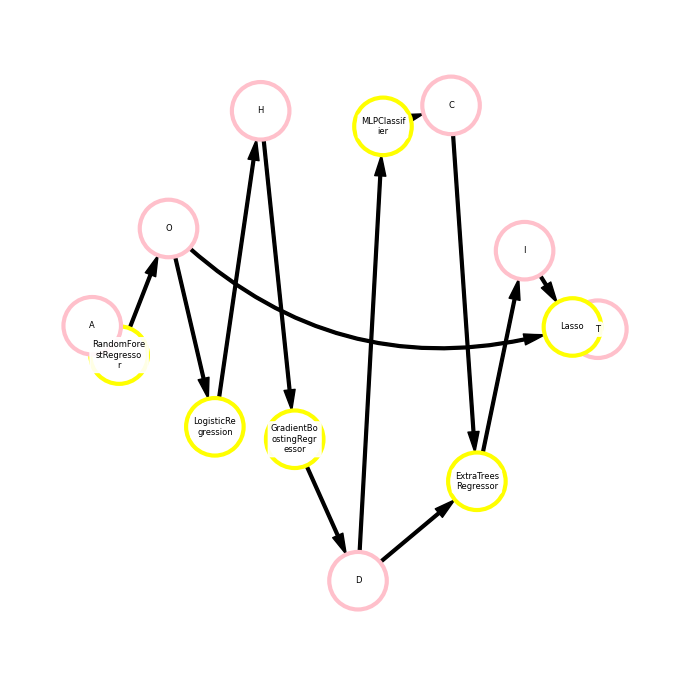

In [45]:
while number <= n:
    run_example() 
    number += 1 
